In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.stats import pareto, t
import scipy.stats as stats
import yfinance as yf
import pandas as pd


In [28]:

# we get yesterday's date yyyy-mm-dd
yesterday = datetime.date.today() - datetime.timedelta(days=1)
# Download historical Bitcoin data
btc = yf.download("BTC-USD", start="2010-01-01", end=yesterday)
spy = yf.download("SPY", start="2010-01-01", end=yesterday) 
# print(btc.head())
btc_df = pd.DataFrame(btc)
btc_df = btc_df.dropna()
btc_df = btc_df.reset_index()
btc_df = btc_df[["Date", "Close"]]
btc_df.head()

spy_df = pd.DataFrame(spy)
spy_df = spy_df.dropna()
spy_df = spy_df.reset_index()
spy_df = spy_df[["Date", "Close"]]
spy_df.head()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,2010-01-04,113.330002
1,2010-01-05,113.629997
2,2010-01-06,113.709999
3,2010-01-07,114.190002
4,2010-01-08,114.570000


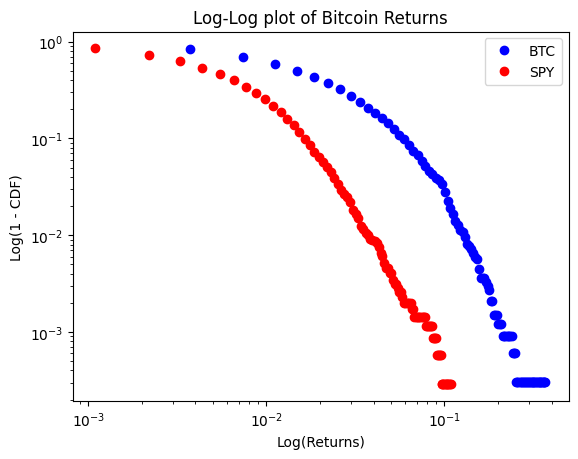

Estimated alpha btc: 6.9104485247252025
Estimated alpha spy: 12.58712948464776


In [29]:


# Calculate returns
btc_df['returns'] = btc_df['Close'].pct_change()
spy_df['returns'] = spy_df['Close'].pct_change()

# Remove NaN values
btc_df = btc_df.dropna()
spy_df = spy_df.dropna()


# Calculate returns
btc_df['returns'] = btc_df['Close'].pct_change()
spy_df['returns'] = spy_df['Close'].pct_change()

# Remove NaN values
btc_df = btc_df.dropna()
spy_df = spy_df.dropna()

# Fit the returns to a power-law model
# We'll use the Pareto distribution as an example
b, loc, scale = pareto.fit(np.abs(btc_df['returns']))
b2, loc, scale = pareto.fit(np.abs(spy_df['returns']))

# Now plot the log-log plot of the CDF
counts, bin_edges = np.histogram(np.abs(btc_df['returns']), bins=100, density=True)
cdf = np.cumsum(counts)
plt.loglog(bin_edges[1:], 1 - cdf/cdf[-1], marker='o', linestyle='none', color='blue')

counts, bin_edges = np.histogram(np.abs(spy_df['returns']), bins=100, density=True)
cdf = np.cumsum(counts)
plt.loglog(bin_edges[1:], 1 - cdf/cdf[-1], marker='o', linestyle='none', color='red')

# Show the plot
plt.xlabel('Log(Returns)')
plt.ylabel('Log(1 - CDF)')
plt.title('Log-Log plot of Bitcoin Returns')
plt.legend(['BTC', 'SPY'])
plt.show()

print(f"Estimated alpha btc: {b}")  # Note that b here is the Pareto alpha
print(f"Estimated alpha spy: {b2}")  # Note that b here is the Pareto alpha

# Interpret the alpha
# Lower alpha -> fatter tail -> higher risk of extreme events



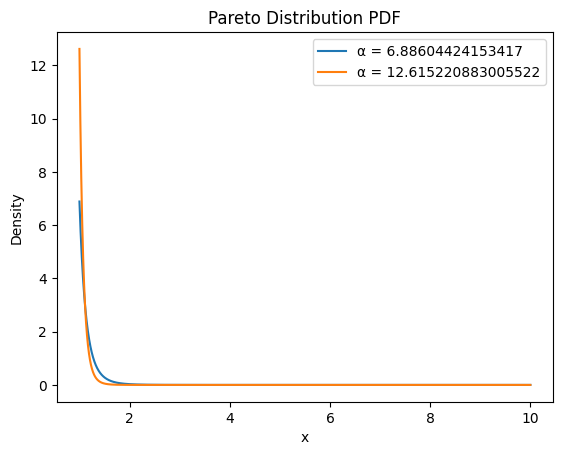

In [30]:
def pareto_pdf(alpha, xm=0, size=10000):
    x = np.linspace(xm, xm*10, size)
    f = alpha * xm**alpha / x**(alpha+1)
    return x, f

def plot_pareto(alpha, xm=1):
    x, f = pareto_pdf(alpha, xm)
    plt.plot(x, f, label=f'α = {alpha}')
    plt.title('Pareto Distribution PDF')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.legend()

alpha_btc = 6.88604424153417  # As obtained previously
alpha_spy = 12.615220883005522  # As obtained previously

plot_pareto(alpha_btc)
plot_pareto(alpha_spy)
plt.show()


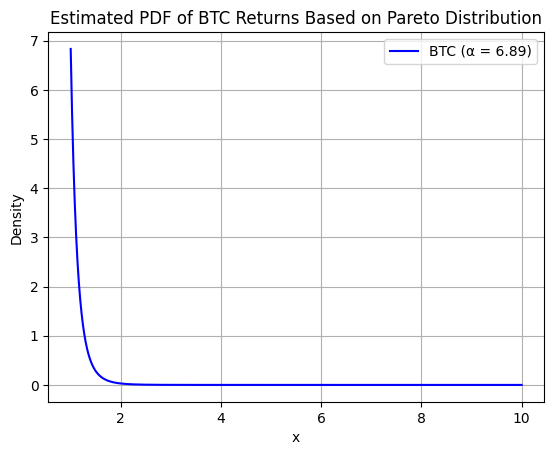

In [31]:

# Define the Pareto PDF function
def pareto_pdf(x, xm, alpha):
    return alpha * xm**alpha * x**(-alpha-1)

# Parameters
alpha_btc = 6.88604424153417
xm = 1  # assuming a standardized Pareto distribution

# Generate x values
x_values = np.linspace(xm+0.001, 10, 1000)  # start slightly above xm to avoid division by zero

# Calculate PDF values
pdf_values_btc = pareto_pdf(x_values, xm, alpha_btc)

# Plot
plt.plot(x_values, pdf_values_btc, label=f'BTC (α = {alpha_btc:.2f})', color='blue')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Estimated PDF of BTC Returns Based on Pareto Distribution')
plt.legend()
plt.grid(True)
plt.show()


<Axes: >

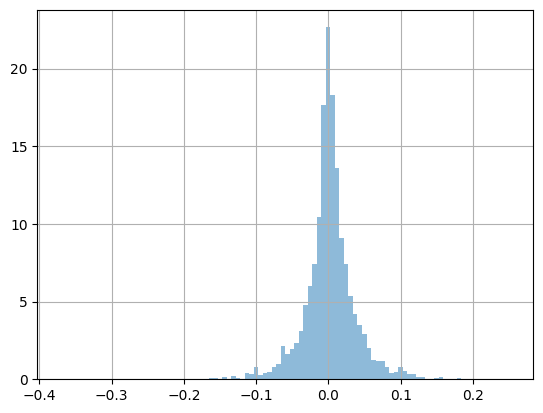

In [32]:
btc_df['returns'].hist(bins=100, density=True, histtype='stepfilled', alpha=0.5, label='BTC')

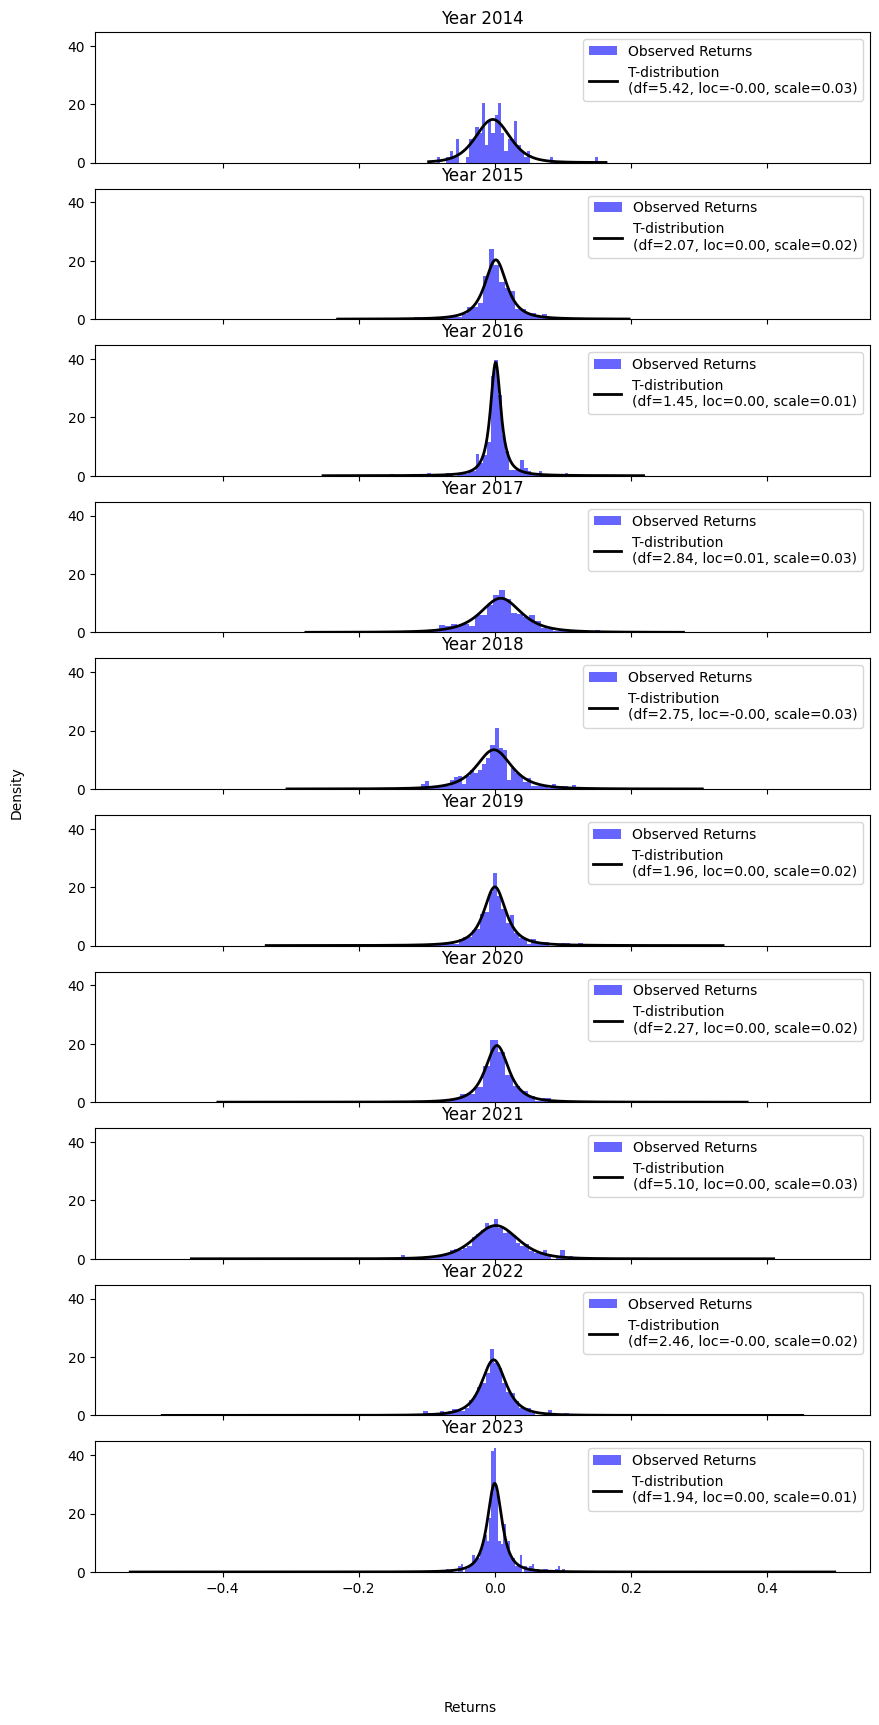

In [33]:
# Group the data by year
btc_df['Year'] = btc_df['Date'].dt.year
groups = btc_df.groupby('Year')

# Create a subplot for each year
fig, axs = plt.subplots(len(groups), 1, figsize=(10, 20), sharex=True, sharey=True)
for i, (year, group) in enumerate(groups):
    # Fit the data to the t-distribution
    df, loc, scale = t.fit(group['returns'].values)

    # Plot the histogram of the data
    axs[i].hist(group['returns'].values, bins=50, density=True, alpha=0.6, color='b', label='Observed Returns')

    # Plot the PDF of the t-distribution with the fitted parameters
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 1000)
    pdf = t.pdf(x, df, loc, scale)
    axs[i].plot(x, pdf, 'k', linewidth=2, label=f"T-distribution\n(df={df:.2f}, loc={loc:.2f}, scale={scale:.2f})")
    axs[i].set_title(f"Year {year}")
    axs[i].legend(loc='best')

# Set the x and y labels
fig.text(0.5, 0.04, 'Returns', ha='center')
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical')

# Show the plot
plt.show()


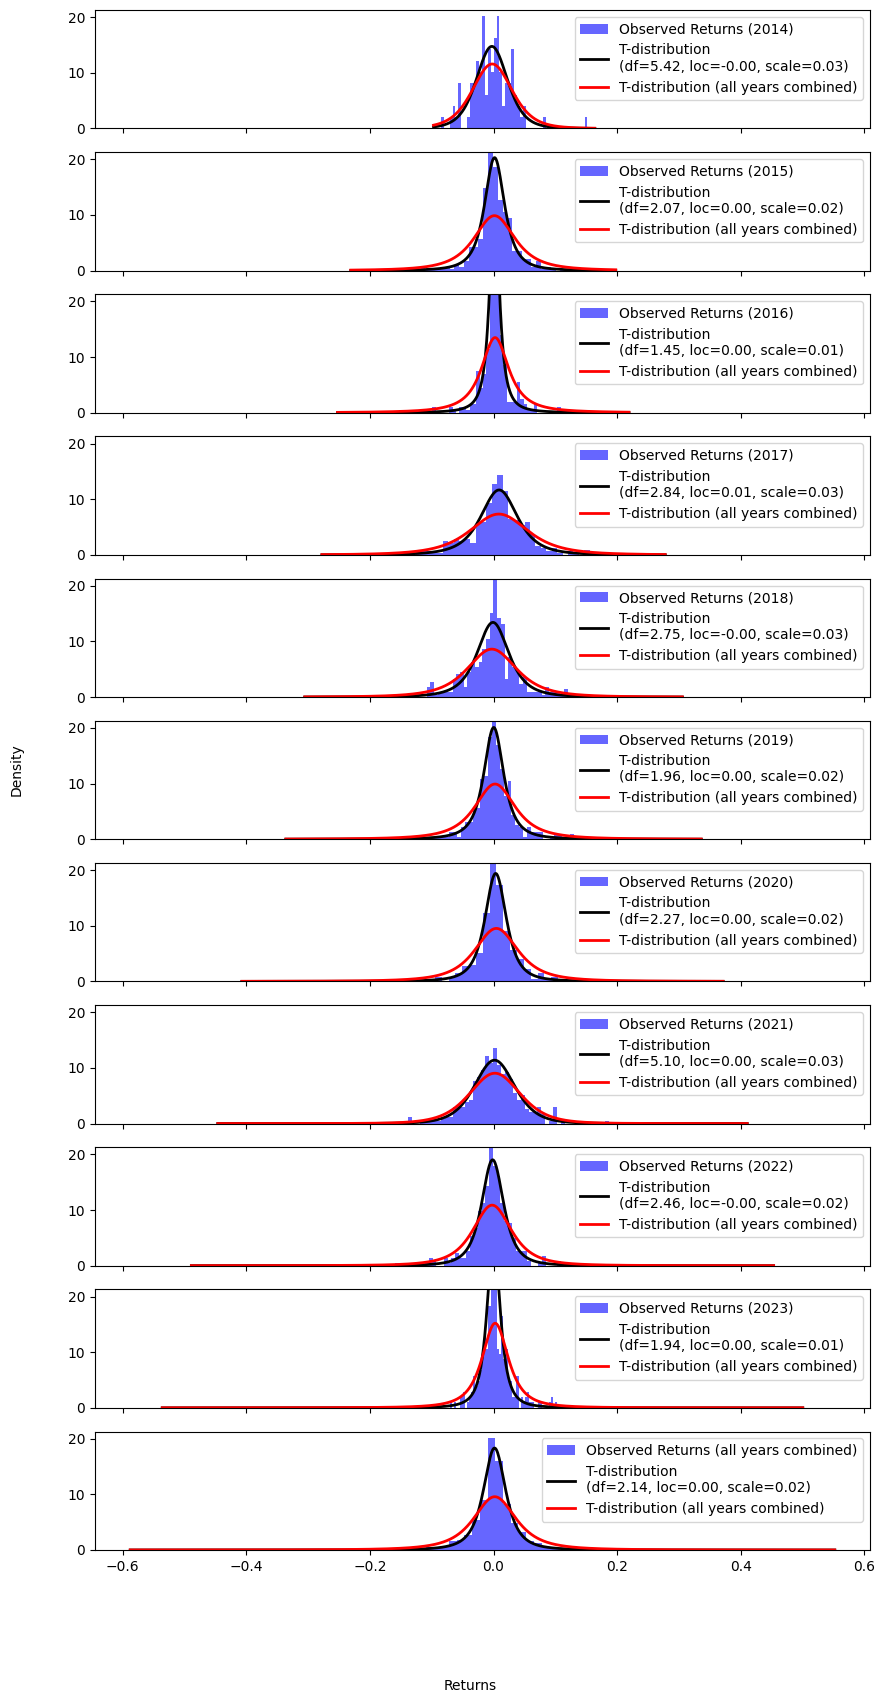

In [34]:
# Group the data by year
btc_df['Year'] = btc_df['Date'].dt.year
groups = btc_df.groupby('Year')

# Create a subplot for each year
fig, axs = plt.subplots(len(groups)+1, 1, figsize=(10, 20), sharex=True, sharey=True)
for i, (year, group) in enumerate(groups):
    # Fit the data to the t-distribution
    df, loc, scale = t.fit(group['returns'].values)

    # Plot the histogram of the data
    axs[i].hist(group['returns'].values, bins=50, density=True, alpha=0.6, color='b', label=f'Observed Returns ({year})')

    # Plot the PDF of the t-distribution with the fitted parameters
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 1000)
    pdf = t.pdf(x, df, loc, scale)
    axs[i].plot(x, pdf, 'k', linewidth=2, label=f"T-distribution\n(df={df:.2f}, loc={loc:.2f}, scale={scale:.2f})")

    # Plot the PDF of the t-distribution with the fitted parameters for all years combined
    pdf_all = t.pdf(x, df, np.mean(group['returns'].values), np.std(group['returns'].values))
    axs[i].plot(x, pdf_all, 'r', linewidth=2, label='T-distribution (all years combined)')

    axs[i].set_ylim([0, max(max(axs[i].get_ylim()), max(pdf_all))])
    axs[i].legend(loc='best')

# Add a subplot for all years combined
df_all = btc_df.drop('Year', axis=1)
df_all['returns'] = df_all['returns'].dropna()
df_all = df_all.reset_index(drop=True)
df_all = df_all.dropna()
df_all = df_all.reset_index(drop=True)

# Fit the data to the t-distribution
df, loc, scale = t.fit(df_all['returns'].values)

# Plot the histogram of the data
axs[-1].hist(df_all['returns'].values, bins=50, density=True, alpha=0.6, color='b', label='Observed Returns (all years combined)')

# Plot the PDF of the t-distribution with the fitted parameters
xmin, xmax = axs[-1].get_xlim()
x = np.linspace(xmin, xmax, 1000)
pdf = t.pdf(x, df, loc, scale)
axs[-1].plot(x, pdf, 'k', linewidth=2, label=f"T-distribution\n(df={df:.2f}, loc={loc:.2f}, scale={scale:.2f})")

# Plot the PDF of the t-distribution with the fitted parameters for all years combined
pdf_all = t.pdf(x, df, np.mean(df_all['returns'].values), np.std(df_all['returns'].values))
axs[-1].plot(x, pdf_all, 'r', linewidth=2, label='T-distribution (all years combined)')

axs[-1].set_ylim([0, max(max(axs[-1].get_ylim()), max(pdf_all))])
axs[-1].legend(loc='best')

# Set the x and y labels
fig.text(0.5, 0.04, 'Returns', ha='center')
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical')

# Show the plot
plt.show()


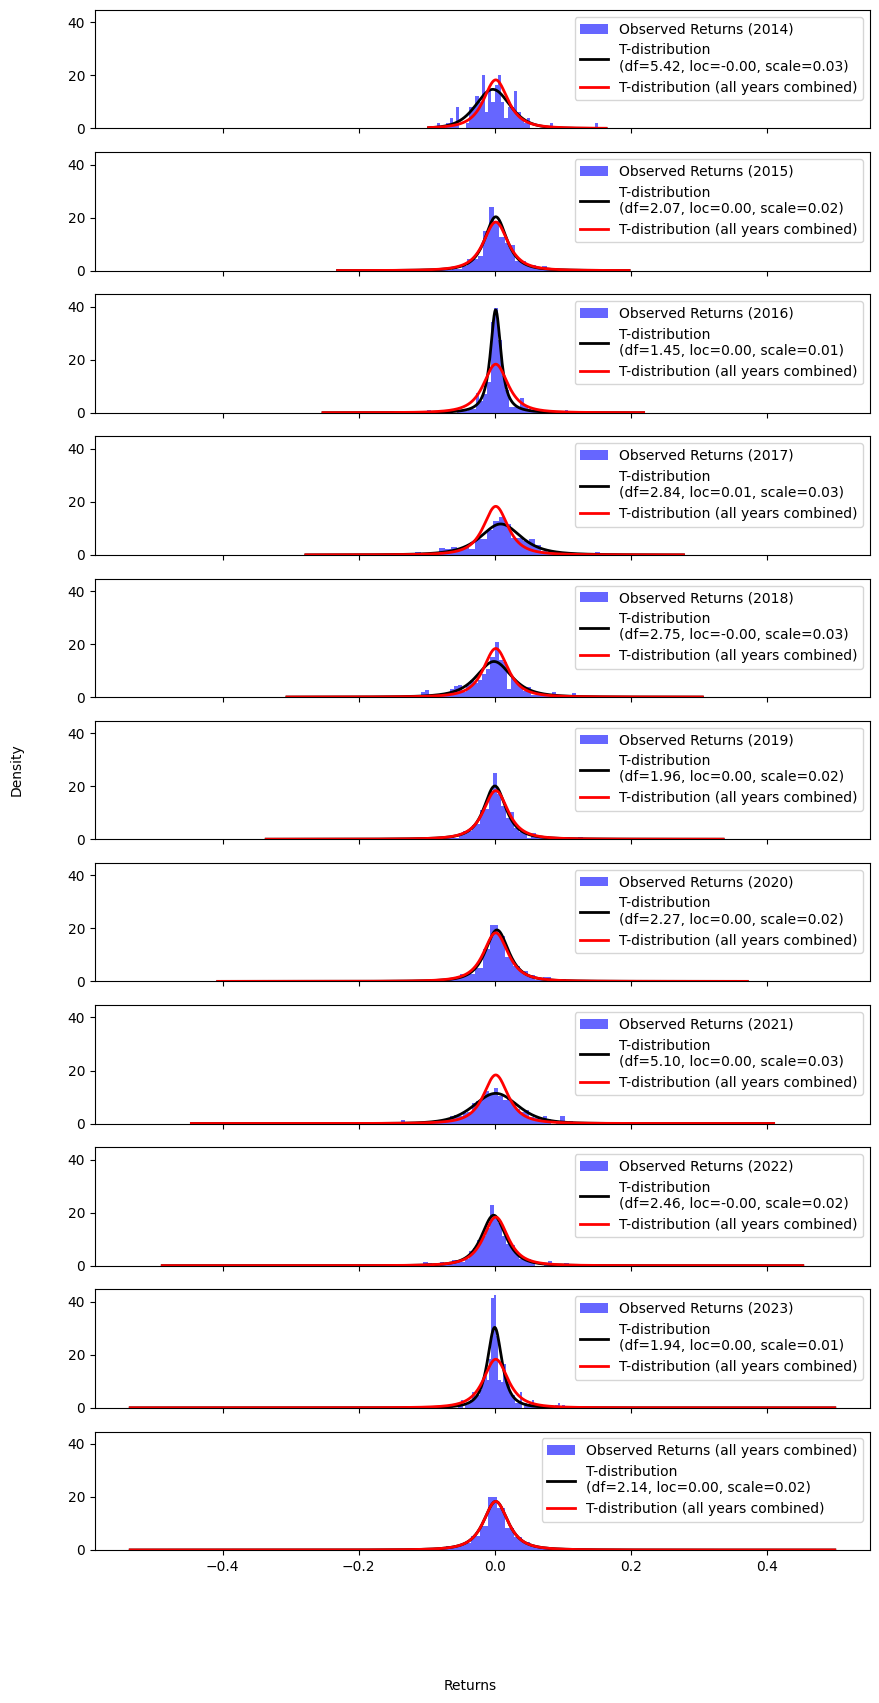

In [35]:
# Group the data by year
btc_df['Year'] = btc_df['Date'].dt.year
groups = btc_df.groupby('Year')

# Compute the parameters for the combined data
df_combined, loc_combined, scale_combined = t.fit(btc_df['returns'].dropna().values)

# Create a subplot for each year
fig, axs = plt.subplots(len(groups)+1, 1, figsize=(10, 20), sharex=True, sharey=True)
for i, (year, group) in enumerate(groups):
    # Fit the data to the t-distribution for the specific year
    df, loc, scale = t.fit(group['returns'].values)

    # Plot the histogram of the data
    axs[i].hist(group['returns'].values, bins=50, density=True, alpha=0.6, color='b', label=f'Observed Returns ({year})')

    # Plot the PDF of the t-distribution with the fitted parameters for the specific year
    xmin, xmax = axs[i].get_xlim()
    x = np.linspace(xmin, xmax, 1000)
    pdf = t.pdf(x, df, loc, scale)
    axs[i].plot(x, pdf, 'k', linewidth=2, label=f"T-distribution\n(df={df:.2f}, loc={loc:.2f}, scale={scale:.2f})")

    # Plot the PDF of the t-distribution with the parameters for all years combined
    pdf_all = t.pdf(x, df_combined, loc_combined, scale_combined)
    axs[i].plot(x, pdf_all, 'r', linewidth=2, label='T-distribution (all years combined)')

    axs[i].legend(loc='best')

# For the last subplot showing all years combined
axs[-1].hist(btc_df['returns'].dropna().values, bins=50, density=True, alpha=0.6, color='b', label='Observed Returns (all years combined)')
pdf = t.pdf(x, df_combined, loc_combined, scale_combined)
axs[-1].plot(x, pdf, 'k', linewidth=2, label=f"T-distribution\n(df={df_combined:.2f}, loc={loc_combined:.2f}, scale={scale_combined:.2f})")
axs[-1].plot(x, pdf_all, 'r', linewidth=2, label='T-distribution (all years combined)')
axs[-1].legend(loc='best')

# Set the x and y labels
fig.text(0.5, 0.04, 'Returns', ha='center')
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical')

# Show the plot
plt.show()



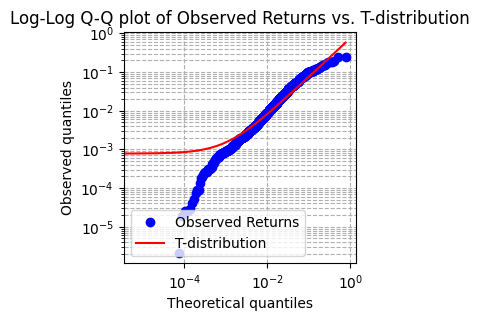

In [49]:

# Generate some random data for demonstration purposes
# observed_returns = np.random.randn(1000)
observed_returns = btc_df['returns'].dropna().values

# Fit the T-distribution
params = stats.t.fit(observed_returns)
df, loc, scale = params

# Generate Q-Q plot on log-log scale
plt.figure(figsize=(3, 3))
stats.probplot(observed_returns, dist=stats.t, sparams=(df, loc, scale), plot=plt)
plt.xscale('log')
plt.yscale('log')
plt.title('Log-Log Q-Q plot of Observed Returns vs. T-distribution')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Observed quantiles')
plt.grid(True, which="both", ls="--")
plt.legend(['Observed Returns','T-distribution'])  
plt.show()


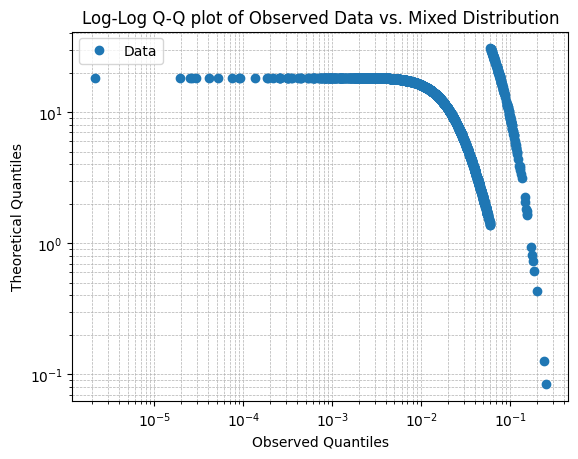

In [50]:
import numpy as np
from scipy.stats import t, pareto

# Sample data
data = btc_df['returns'].dropna().values
# 1. Fit T-distribution
df, loc, scale = t.fit(data)

# 2. Determine threshold for tails
threshold_upper = np.percentile(data, 95)  # 95th percentile, for example
threshold_lower = np.percentile(data, 5)   # 5th percentile

# Data for tails
tail_data_upper = data[data > threshold_upper]
tail_data_lower = data[data < threshold_lower]

# 3. Fit Pareto to tails
b_upper, loc_upper, scale_upper = pareto.fit(tail_data_upper)
b_lower, loc_lower, scale_lower = pareto.fit(tail_data_lower)

# 4. Combined PDF
def combined_pdf(x):
    if x > threshold_upper:
        return pareto.pdf(x, b_upper, loc_upper, scale_upper)
    elif x < threshold_lower:
        return pareto.pdf(x, b_lower, loc_lower, scale_lower)
    else:
        return t.pdf(x, df, loc, scale)

# Create quantiles for observed data and theoretical distribution
observed_quantiles = np.sort(data)
theoretical_quantiles = [combined_pdf(x) for x in observed_quantiles]

# Log-log plot
plt.loglog(observed_quantiles, theoretical_quantiles, 'o', label="Data")
plt.xlabel("Observed Quantiles")
plt.ylabel("Theoretical Quantiles")
plt.title("Log-Log Q-Q plot of Observed Data vs. Mixed Distribution")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()# Now you can use combined_pdf to get the probability density for any value


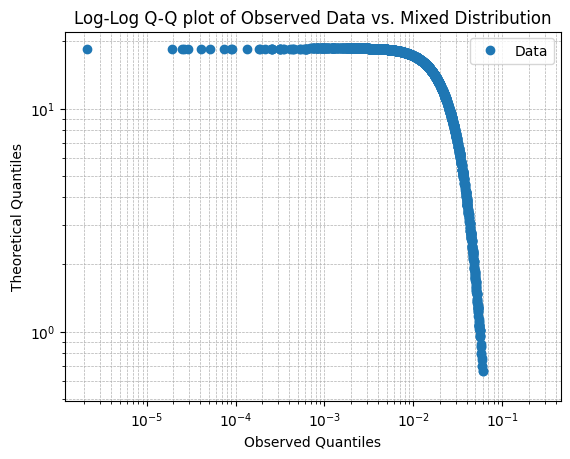

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, pareto

# Sample data
data = btc_df['returns'].dropna().values

# Determine thresholds for tails
threshold_upper = np.percentile(data, 95)
threshold_lower = np.percentile(data, 5)

# Data for center and tails
center_data = data[(data <= threshold_upper) & (data >= threshold_lower)]
tail_data_upper = data[data > threshold_upper]
tail_data_lower = data[data < threshold_lower]

# Fit T-distribution to center
df, loc, scale = t.fit(center_data)

# Fit Pareto to tails
b_upper, loc_upper, scale_upper = pareto.fit(tail_data_upper, floc=threshold_upper)
b_lower, loc_lower, scale_lower = pareto.fit(-tail_data_lower, floc=-threshold_lower)  # Note the negative sign

# Combined PDF
def combined_pdf(x):
    if x > threshold_upper:
        return pareto.pdf(x - threshold_upper, b_upper) / scale_upper
    elif x < threshold_lower:
        return pareto.pdf(-x + threshold_lower, b_lower) / scale_lower
    else:
        return t.pdf(x, df, loc, scale)

# Quantiles for observed data and theoretical distribution
observed_quantiles = np.sort(data)
theoretical_quantiles = np.array([combined_pdf(x) for x in observed_quantiles])

# Log-log plot
plt.loglog(observed_quantiles, theoretical_quantiles, 'o', label="Data")
plt.xlabel("Observed Quantiles")
plt.ylabel("Theoretical Quantiles")
plt.title("Log-Log Q-Q plot of Observed Data vs. Mixed Distribution")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()


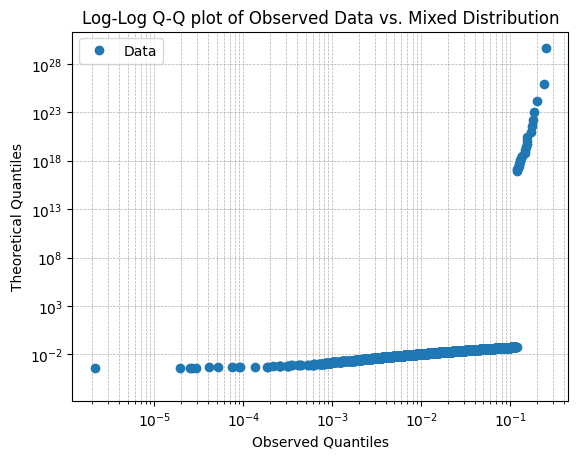

In [52]:
# Inverse CDF for the mixed distribution
def combined_icdf(p):
    # Find the probabilities where each distribution applies
    p_threshold_lower = t.cdf(threshold_lower, df, loc, scale)
    p_threshold_upper = t.cdf(threshold_upper, df, loc, scale)
    
    if p < p_threshold_lower:
        return -pareto.ppf(1 - p, b_lower) + threshold_lower
    elif p_threshold_lower <= p <= p_threshold_upper:
        return t.ppf(p, df, loc, scale)
    else:
        return pareto.ppf(1 - (1-p), b_upper) + threshold_upper

# Generate theoretical quantiles
n = len(data)
theoretical_probs = (np.arange(n) + 0.5) / n
theoretical_quantiles = np.array([combined_icdf(p) for p in theoretical_probs])

# Log-log plot
plt.loglog(np.sort(data), theoretical_quantiles, 'o', label="Data")
plt.xlabel("Observed Quantiles")
plt.ylabel("Theoretical Quantiles")
plt.title("Log-Log Q-Q plot of Observed Data vs. Mixed Distribution")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()
